# Topic Classification Using Unsupervised and Supervised Approaches Part 2
This assignment compares how well unsupervised matrix factorisation and two supervised learning models classify [BBC News data](https://www.kaggle.com/competitions/learn-ai-bbc/data). This is the second notebook and focuses on the supervised learning models.

In [1]:
# general libraries
import configparser
import numpy as np
import pandas as pd
from time import time

# visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

# modelling libraries
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import spacy
from spacy.tokens import DocBin

# get rid of the seaborn FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# load the data
train = pd.read_csv('./data/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('./data/learn-ai-bbc/BBC News Test.csv')

# allocate data and perform operations on gpu. Will raise an error if no GPU is available.
spacy.require_gpu()
# load the english spacy model
nlp = spacy.load("en_core_web_lg")

# check out the number of tokens in the articles
train['NumChars'] = train.Text.apply(lambda x: len(x))
train['NumWords'] = train.Text.apply(lambda x: len(x.split()))

# remove articles in the top 1%
top = np.quantile(train.NumWords, q=0.99)
train_sub = train.loc[train.NumWords < top]

## Task 6: Supervised Learning - Spacy
Spacy has an inbuilt text categoriser ('textcat') that can be added as a component to its NLP pipeline.

There are 3 CPU architectures available:
- Stacked ensemble of a linear BoW and neural network model. The neural network is built on top of a Tok2Vec (token to vector) layer and uses attention. This is the default architecture.
- n-gram BoW model. Runs the fastest, but has particular trouble with short texts (Not too much of an issue in this case, but could be if analysing customer feedback for example).
- Neural network model where token vectors are calculated using a CNN. According to the documentation, it's typically less accurate than the default but faster.

There is one GPU architecture available:
- A transformer model from the HuggingFace transformers library with pre-trained weights and a PyTorch implementation.

**The first model trained and evaluated was a BoW model.**

In [3]:
# check if textcat is part of the pipeline
if nlp.has_pipe("textcat"):
    pass
else:
    textcat = nlp.add_pipe("textcat", last=True)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'textcat']

In [4]:
# add the labels (categories) to the pipeline component
textcat.add_label("business")
textcat.add_label("entertainment")
textcat.add_label("politics")
textcat.add_label("sport")
textcat.add_label("tech")

# double-check they've been added
textcat.labels

('business', 'entertainment', 'politics', 'sport', 'tech')

In [5]:
default_config = nlp.get_pipe_meta("textcat").default_config
default_config

{'threshold': 0.0,
 'model': {'@architectures': 'spacy.TextCatEnsemble.v2',
  'linear_model': {'@architectures': 'spacy.TextCatBOW.v2',
   'exclusive_classes': True,
   'ngram_size': 1,
   'no_output_layer': False},
  'tok2vec': {'@architectures': 'spacy.Tok2Vec.v2',
   'embed': {'@architectures': 'spacy.MultiHashEmbed.v2',
    'width': 64,
    'rows': [2000, 2000, 500, 1000, 500],
    'attrs': ['NORM', 'LOWER', 'PREFIX', 'SUFFIX', 'SHAPE'],
    'include_static_vectors': False},
   'encode': {'@architectures': 'spacy.MaxoutWindowEncoder.v2',
    'width': 64,
    'window_size': 1,
    'maxout_pieces': 3,
    'depth': 2}}},
 'scorer': {'@scorers': 'spacy.textcat_scorer.v2'}}

First rejig the config file for **efficiency**, noting it changes the default model architecture from an ensemble to a BoW.
- Step 1: generate a base config file using https://spacy.io/usage/training#quickstart:
    - Components: textcat
    - Text classification: Exclusive categories
    - Hardware: CPU
    - Optimise for: efficiency
- Step 2: Create a complete config file with all the other components auto-filled to their defaults

In [6]:
# CLI command
!python -m spacy init fill-config ./configs/base_efficiency_cpu_config.cfg ./configs/efficiency_cpu_config.cfg --diff
# --diff produces a helpful comparison to the base config file (i.e. what's been added/removed)

✔ Auto-filled config with all values

============================= START CONFIG DIFF =============================

[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = null
seed = 0

[nlp]
lang = "en"
pipeline = ["textcat"]
batch_size = 1000
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatBOW.v2"
exclusive_classes = true
ngram_size = 1
no_output_layer = false
nO = null

[corpora]

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0
gold_preproc = false
limit = 0
augmenter = null

[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0
gold_preproc = false
limit = 0
augmenter = null

[tra

In [7]:
# view the configuration file
def read_spacy_config(file_path):
    config = configparser.ConfigParser()
    config.read(file_path)

    config_dict = {}
    for section in config.sections():
        config_dict[section] = {}
        for option in config.options(section):
            config_dict[section][option] = config.get(section, option)

    return config_dict


file_path = './configs/efficiency_cpu_config.cfg'
textcat_config = read_spacy_config(file_path)
textcat_config

{'paths': {'train': 'null',
  'dev': 'null',
  'vectors': 'null',
  'init_tok2vec': 'null'},
 'system': {'gpu_allocator': 'null', 'seed': '0'},
 'nlp': {'lang': '"en"',
  'pipeline': '["textcat"]',
  'batch_size': '1000',
  'disabled': '[]',
  'before_creation': 'null',
  'after_creation': 'null',
  'after_pipeline_creation': 'null',
  'tokenizer': '{"@tokenizers":"spacy.Tokenizer.v1"}',
  'vectors': '{"@vectors":"spacy.Vectors.v1"}'},
 'components': {},
 'components.textcat': {'factory': '"textcat"',
  'scorer': '{"@scorers":"spacy.textcat_scorer.v2"}',
  'threshold': '0.0'},
 'components.textcat.model': {'@architectures': '"spacy.TextCatBOW.v2"',
  'exclusive_classes': 'true',
  'ngram_size': '1',
  'no_output_layer': 'false',
  'no': 'null'},
 'corpora': {},
 'corpora.dev': {'@readers': '"spacy.Corpus.v1"',
  'path': '${paths.dev}',
  'max_length': '0',
  'gold_preproc': 'false',
  'limit': '0',
  'augmenter': 'null'},
 'corpora.train': {'@readers': '"spacy.Corpus.v1"',
  'path': '$

In [8]:
# split the data into a training and dev set (80/20 split)
# ensure that the category splits are roughly even
train_data, dev_data = train_test_split(train_sub, stratify=train_sub.Category, test_size=0.2, random_state=42)
train_data.reset_index(inplace=True, drop=True)
dev_data.reset_index(inplace=True, drop=True)


# convert the data to spacy's required training format: https://spacy.io/api/data-formats#binary-training
def convert_data(output_path, df, label='Category'):
    # extract all the unique categories
    cats = set(df[label])

    # create a one-hot-dictionary for each unique category
    one_hot_dicts = {}
    for c1 in cats:
        one_hot_dict = {c2: (1 if c2 == c1 else 0) for c2 in cats}
        one_hot_dicts[c1] = one_hot_dict
    print(one_hot_dicts)

    # create spacy and DocBin objects
    nlp = spacy.blank('en')
    db = DocBin()

    # for each row in the dataframe...
    for idx, row in df.iterrows():
        # locate just the text and label information
        text = row['Text']
        cat = row['Category']

        # make a doc from the text
        doc = nlp.make_doc(text)
        # add the relevant one-hot-dictionary
        doc.cats = one_hot_dicts[cat]
        # print(one_hot_dicts[cat])
        # add it to the DocBin object
        db.add(doc)

    # write the DocBin object to disk
    db.to_disk(output_path)


convert_data("./corpora/train.spacy", df=train_data)
convert_data("./corpora/dev.spacy", df=dev_data)

{'sport': {'sport': 1, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'business': {'sport': 0, 'business': 1, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'tech': {'sport': 0, 'business': 0, 'tech': 1, 'politics': 0, 'entertainment': 0}, 'politics': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 1, 'entertainment': 0}, 'entertainment': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 1}}
{'sport': {'sport': 1, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'business': {'sport': 0, 'business': 1, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'tech': {'sport': 0, 'business': 0, 'tech': 1, 'politics': 0, 'entertainment': 0}, 'politics': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 1, 'entertainment': 0}, 'entertainment': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 1}}


In [10]:
# train the model: https://spacy.io/usage/training#quickstart
# override various config sections using the syntax: --section.option
t0 = time()
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs --paths.train ./corpora/train.spacy --paths.dev ./corpora/dev.spacy --gpu-id 0
print("Done in %0.3fm." % ((time() - t0)/60))

ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        5.90    0.06
  0     200         15.30       91.67    0.92
  0     400          4.44       91.37    0.91
  0     600          2.67       96.13    0.96
  0     800          2.25       93.55    0.94
  0    1000          2.77       95.39    0.95
  1    1200          1.65       96.54    0.97
  1    1400          0.33       96.44    0.96
  1    1600          0.39       95.76    0.96
  1    1800          0.13       96.44    0.96
  1    2000          0.87       95.76    0.96
  1    2200          0.01       96.91    0.97
  2    2400          0.00       97.21    0.97
  2    2600          0.7

In [13]:
# evaluate model performance
!python -m spacy evaluate ./outputs/efficiency-cpu-model-best/ ./corpora/train.spacy --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.92 
SPEED               242495


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00    99.63    99.81
tech            100.00   100.00   100.00
politics         99.54   100.00    99.77
entertainment   100.00   100.00   100.00


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics           1.00
entertainment      1.00



In [14]:
!python -m spacy evaluate ./outputs/efficiency-cpu-model-best/ ./corpora/dev.spacy --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   97.64 
SPEED               184760


=========================== Textcat F (per label) ===========================

                     P        R       F
sport            98.55    98.55   98.55
business         95.59    97.01   96.30
tech             98.04    98.04   98.04
politics        100.00    94.44   97.14
entertainment    96.43   100.00   98.18


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics           1.00
entertainment      1.00



We can see therefore that the scoring during model training is for the dev set (as it should be). Also, the F-score on the dev set is only slightly lower than the training set (97.6 vs 99.9), indicating that it's not overfitting.

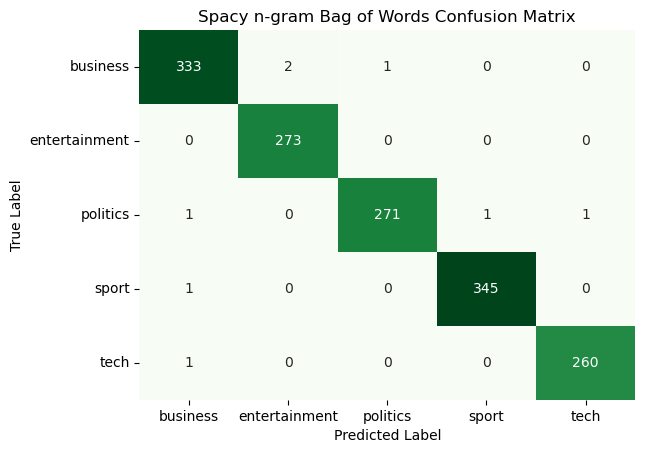

In [15]:
# load the model
nlp_efficiency = spacy.load("./outputs/efficiency-cpu-model-best")

def generate_predictions(df, text_col='Text', label_col='Category', textcat_model=nlp_efficiency):
    data = df[text_col].to_list()

    pred_cats = []
    for article in data:
        doc = textcat_model(article)
        scores_dict = doc.cats
        pred_cat = max(scores_dict, key=lambda k: scores_dict[k])
        pred_cats.append(pred_cat)
    if label_col is None:
        pred_df = pd.DataFrame(data = {'ArticleId': df['ArticleId'], 'PredictedLabel': pred_cats, 'Text': df[text_col]})
    else:
        pred_df = pd.DataFrame(data = {'ArticleId': df['ArticleId'], 'Actual': df[label_col], 
                                       'Predicted': pred_cats, 'Text': df[text_col]})

    return pred_df


train_preds = generate_predictions(train)


def plot_confusion_matrix(true_labels, predicted_labels, title,
                          cats=['business', 'entertainment', 'politics', 'sport', 'tech']):
    cm = confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_df = pd.DataFrame(cm, columns=cats, index=cats)
    ax = sns.heatmap(cm_df, annot=True, fmt=".0f", cbar=False, cmap="Greens")
    ax.set(xlabel="Predicted Label", ylabel="True Label", title=title)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, title='Spacy n-gram Bag of Words Confusion Matrix')

In [18]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training accuracy:", accuracy)

f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training F1 score:", f1)

# make predictions
test_preds = generate_predictions(test, label_col=None)

kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
kaggle_submission.to_csv('./outputs/kaggle submission efficient textcat.csv', index=False)

Training accuracy: 0.9946308724832215
Training F1 score: 0.9946284051192686


The model performed well on both the training and test sets, achieving a near 100% accuracy on the full training data and around 98% on the test data.

**The second model trained and evaluated was stacked ensemble model.**

Now rejig the config file for **accuracy**. This keeps the default model architecture.
- Step 1: generate a base config file using https://spacy.io/usage/training#quickstart:
    - Components: textcat
    - Text classification: Exclusive categories
    - Hardware: CPU
    - Optimise for: accuracy
- Step 2: Create a complete config file with all the other components auto-filled to their defaults

In [19]:
# CLI command
!python -m spacy init fill-config ./configs/base_accuracy_cpu_config.cfg ./configs/accuracy_cpu_config.cfg --diff

✔ Auto-filled config with all values

============================= START CONFIG DIFF =============================

[paths]
train = null
dev = null
vectors = "en_core_web_lg"
init_tok2vec = null

[system]
gpu_allocator = null
seed = 0

[nlp]
lang = "en"
pipeline = ["tok2vec","textcat"]
batch_size = 1000
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
nO = null

[components.textcat.model.linear_model]
@architectures = "spacy.TextCatBOW.v2"
exclusive_classes = true
ngram_size = 1
no_output_layer = false
nO = null

[components.textcat.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}
upstream = "*"

[components.

In [20]:
# view the configuration file
file_path = './configs/accuracy_cpu_config.cfg'
textcat_config = read_spacy_config(file_path)
textcat_config

{'paths': {'train': 'null',
  'dev': 'null',
  'vectors': '"en_core_web_lg"',
  'init_tok2vec': 'null'},
 'system': {'gpu_allocator': 'null', 'seed': '0'},
 'nlp': {'lang': '"en"',
  'pipeline': '["tok2vec","textcat"]',
  'batch_size': '1000',
  'disabled': '[]',
  'before_creation': 'null',
  'after_creation': 'null',
  'after_pipeline_creation': 'null',
  'tokenizer': '{"@tokenizers":"spacy.Tokenizer.v1"}',
  'vectors': '{"@vectors":"spacy.Vectors.v1"}'},
 'components': {},
 'components.textcat': {'factory': '"textcat"',
  'scorer': '{"@scorers":"spacy.textcat_scorer.v2"}',
  'threshold': '0.0'},
 'components.textcat.model': {'@architectures': '"spacy.TextCatEnsemble.v2"',
  'no': 'null'},
 'components.textcat.model.linear_model': {'@architectures': '"spacy.TextCatBOW.v2"',
  'exclusive_classes': 'true',
  'ngram_size': '1',
  'no_output_layer': 'false',
  'no': 'null'},
 'components.textcat.model.tok2vec': {'@architectures': '"spacy.Tok2VecListener.v1"',
  'width': '${components.tok

In [22]:
# train the model: https://spacy.io/usage/training#quickstart
# override various config sections using the syntax: --section.option
t0 = time()
!python -m spacy train ./configs/accuracy_cpu_config.cfg --output ./outputs --paths.train ./corpora/train.spacy --paths.dev ./corpora/dev.spacy --gpu-id 0
print("Done in %0.3fm." % ((time() - t0)/60))

ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ------------  ----------  ------
  0       0          0.00          0.16        6.39    0.06
  0     200         17.95         38.60       14.37    0.14
  0     400         30.34         38.16       29.65    0.30
  0     600         22.97         33.68       43.78    0.44
  0     800         14.53         30.63       51.74    0.52
  0    1000         36.00         26.22       43.05    0.43
  1    1200         16.56         21.49       40.46    0.40
  1    1400         27.72         20.73       73.65    0.74
  1    1600         21.78         15.13       71.58    0.72
  1    1800         44.47         14.34    

In [28]:
# evaluate model performance
!python -m spacy evaluate ./outputs/accuracy-cpu-model-best/ ./corpora/train.spacy

ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0


In [25]:
!python -m spacy evaluate ./outputs/accuracy-cpu-model-best/ ./corpora/dev.spacy --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   94.47 
SPEED               37859 


=========================== Textcat F (per label) ===========================

                    P        R       F
sport           95.83   100.00   97.87
business        98.31    86.57   92.06
tech            90.91    98.04   94.34
politics        89.66    96.30   92.86
entertainment   98.04    92.59   95.24


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           0.99
tech               1.00
politics           0.99
entertainment      1.00



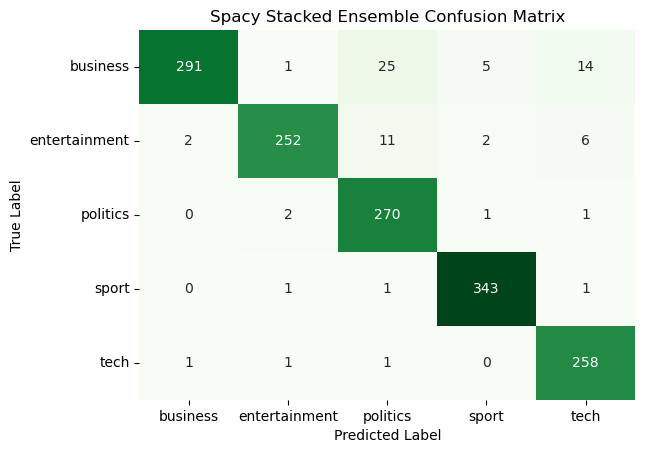

In [29]:
# load the model
nlp_accuracy = spacy.load("./outputs/accuracy-cpu-model-best")

train_preds = generate_predictions(train, textcat_model=nlp_accuracy)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, title='Spacy Stacked Ensemble Confusion Matrix')

In [31]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training accuracy:", accuracy)

f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training F1 score:", f1)

# make predictions
test_preds = generate_predictions(test, label_col=None, textcat_model=nlp_accuracy)

kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
kaggle_submission.to_csv('./outputs/kaggle submission accurate textcat.csv', index=False)

Training accuracy: 0.9489932885906041
Training F1 score: 0.9488005422471573


The model performed reasonably well, but not quite as well as the simpler Bag of Words classifier (95% on the training data and 94% on the test data). It appears to have missclassified a reasonable number of political and tech articles as business articles.

**The third model trained and evaluated was a CPU-based CNN model.**

In [40]:
# view the configuration file - there was no helpful widget to fill out the configuration
file_path = './configs/cnn_cpu_config.cfg'
textcat_config = read_spacy_config(file_path)
textcat_config

{'paths': {'train': 'null',
  'dev': 'null',
  'vectors': 'null',
  'init_tok2vec': 'null'},
 'system': {'gpu_allocator': 'null', 'seed': '0'},
 'nlp': {'lang': '"en"',
  'pipeline': '["tok2vec", "textcat"]',
  'batch_size': '1000',
  'disabled': '[]',
  'before_creation': 'null',
  'after_creation': 'null',
  'after_pipeline_creation': 'null',
  'tokenizer': '{"@tokenizers":"spacy.Tokenizer.v1"}',
  'vectors': '{"@vectors":"spacy.Vectors.v1"}'},
 'components': {},
 'components.textcat': {'factory': '"textcat"',
  'scorer': '{"@scorers":"spacy.textcat_scorer.v2"}',
  'threshold': '0.0'},
 'components.textcat.model': {'@architectures': '"spacy.TextCatCNN.v2"',
  'exclusive_classes': 'True',
  'no': 'null'},
 'components.textcat.model.tok2vec': {'@architectures': '"spacy.Tok2VecListener.v1"',
  'width': '${components.tok2vec.model.width}',
  'upstream': '"*"'},
 'components.tok2vec': {'factory': '"tok2vec"'},
 'components.tok2vec.model': {'@architectures': '"spacy.HashEmbedCNN.v2"',
  'p

In [39]:
# train the model: https://spacy.io/usage/training#quickstart
# override various config sections using the syntax: --section.option
t0 = time()
!python -m spacy train ./configs/cnn_cpu_config.cfg --output ./outputs --paths.train ./corpora/train.spacy --paths.dev ./corpora/dev.spacy --gpu-id 0
print("Done in %0.3fm." % ((time() - t0)/60))

ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ------------  ----------  ------
  0       0          0.00          0.16        5.90    0.06
  0     200          0.00         32.21       15.53    0.16
  0     400          0.02         23.15       57.57    0.58
  0     600          0.03         16.59       73.98    0.74
  0     800          0.04         10.89       79.87    0.80
  0    1000          0.05          9.43       83.35    0.83
  1    1200          0.07          9.16       88.66    0.89
  1    1400          0.03          3.60       89.08    0.89
  1    1600          0.05          4.87       90.08    0.90
  1    1800          0.05          3.34    

In [43]:
# evaluate model performance
!python -m spacy evaluate ./outputs/cnn-cpu-model-best/ ./corpora/train.spacy --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.73 
SPEED               114347


=========================== Textcat F (per label) ===========================

                     P        R        F
sport            99.64   100.00    99.82
business        100.00    99.63    99.81
tech             99.51    99.51    99.51
politics        100.00   100.00   100.00
entertainment    99.53    99.53    99.53


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics           1.00
entertainment      1.00



In [44]:
!python -m spacy evaluate ./outputs/cnn-cpu-model-best/ ./corpora/dev.spacy --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   95.95 
SPEED               51325 


=========================== Textcat F (per label) ===========================

                     P        R       F
sport            90.79   100.00   95.17
business        100.00    94.03   96.92
tech             98.04    98.04   98.04
politics         96.30    96.30   96.30
entertainment    96.08    90.74   93.33


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics           0.99
entertainment      0.99



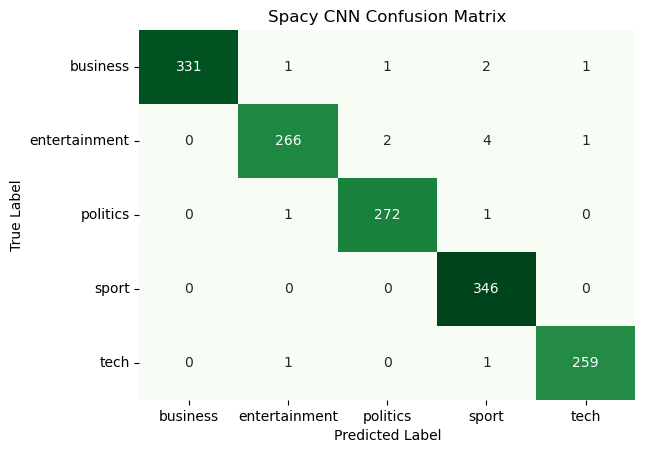

In [45]:
# load the model
nlp_cnn = spacy.load("./outputs/cnn-cpu-model-best")

train_preds = generate_predictions(train, textcat_model=nlp_cnn)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, title='Spacy CNN Confusion Matrix')

In [46]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training accuracy:", accuracy)

f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training F1 score:", f1)

# make predictions
test_preds = generate_predictions(test, label_col=None, textcat_model=nlp_cnn)

kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
kaggle_submission.to_csv('./outputs/kaggle submission cnn textcat.csv', index=False)

Training accuracy: 0.9892617449664429
Training F1 score: 0.9892581389403271


Model performance was close to the Bag of Words approach, but dropped a little on the test data (98% vs 94%). Although the margins are quite small, there was also more of a gap between the train and dev set accuracies, indicating that some overfitting might have been occurring. This model struggled most (relatively speaking) with distinguishing sports and entertainment articles - i.e. missclassifying entertainment articles as sport but not the other way around.

**The fourth model trained and evaluated was a transformer-based CNN model.**

Rejig the config file for **GPU efficiency**.
- Step 1: generate a base config file using https://spacy.io/usage/training#quickstart:
    - Components: textcat
    - Text classification: Exclusive categories
    - Hardware: GPU (transformer)
    - Optimise for: efficiency
- Step 2: Create a complete config file with all the other components auto-filled to their defaults

In [47]:
# CLI command
!python -m spacy init fill-config ./configs/base_efficiency_gpu_config.cfg ./configs/efficiency_gpu_config.cfg --diff

✔ Auto-filled config with all values

============================= START CONFIG DIFF =============================

[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 128
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatCNN.v2"
exclusive_classes = true
nO = null

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
grad_factor = 1.0
pooling = {"@layers":"reduce_mean.v1"}
upstream = "*"

[components.transformer]
factory = "transformer"
max_batch_items = 4096
set_extra_annotations = {"@annotation_setters":"spacy

In [48]:
# view the configuration file
file_path = './configs/efficiency_gpu_config.cfg'
textcat_config = read_spacy_config(file_path)
textcat_config

{'paths': {'train': 'null',
  'dev': 'null',
  'vectors': 'null',
  'init_tok2vec': 'null'},
 'system': {'gpu_allocator': '"pytorch"', 'seed': '0'},
 'nlp': {'lang': '"en"',
  'pipeline': '["transformer","textcat"]',
  'batch_size': '128',
  'disabled': '[]',
  'before_creation': 'null',
  'after_creation': 'null',
  'after_pipeline_creation': 'null',
  'tokenizer': '{"@tokenizers":"spacy.Tokenizer.v1"}',
  'vectors': '{"@vectors":"spacy.Vectors.v1"}'},
 'components': {},
 'components.textcat': {'factory': '"textcat"',
  'scorer': '{"@scorers":"spacy.textcat_scorer.v2"}',
  'threshold': '0.0'},
 'components.textcat.model': {'@architectures': '"spacy.TextCatCNN.v2"',
  'exclusive_classes': 'true',
  'no': 'null'},
 'components.textcat.model.tok2vec': {'@architectures': '"spacy-transformers.TransformerListener.v1"',
  'grad_factor': '1.0',
  'pooling': '{"@layers":"reduce_mean.v1"}',
  'upstream': '"*"'},
 'components.transformer': {'factory': '"transformer"',
  'max_batch_items': '4096'

In [49]:
# train the model: https://spacy.io/usage/training#quickstart
# override various config sections using the syntax: --section.option
t0 = time()
!python -m spacy train ./configs/efficiency_gpu_config.cfg --output ./outputs --paths.train ./corpora/train.spacy --paths.dev ./corpora/dev.spacy --gpu-id 0
print("Done in %0.3fm." % ((time() - t0)/60))

ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
config.json: 100%|█████████████████████████████| 481/481 [00:00<00:00, 4.36MB/s]
vocab.json: 100%|████████████████████████████| 899k/899k [00:00<00:00, 68.1MB/s]
merges.txt: 100%|████████████████████████████| 456k/456k [00:00<00:00, 20.0MB/s]
tokenizer.json: 100%|██████████████████████| 1.36M/1.36M [00:00<00:00, 48.4MB/s]
model.safetensors: 100%|██████████████████████| 499M/499M [00:01<00:00, 482MB/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'textcat']
ℹ Initial learn rate: 0.0
E    

In [50]:
# evaluate model performance
!python -m spacy evaluate ./outputs/efficiency-gpu-model-best/ ./corpora/train.spacy --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   98.76 
SPEED               10382 


=========================== Textcat F (per label) ===========================

                     P       R       F
sport           100.00   99.64   99.82
business         98.15   98.88   98.52
tech             98.49   96.55   97.51
politics         99.08   99.08   99.08
entertainment    98.17   99.53   98.85


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics           1.00
entertainment      1.00



In [51]:
!python -m spacy evaluate ./outputs/efficiency-gpu-model-best/ ./corpora/dev.spacy --gpu-id 0

ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   97.31 
SPEED               9112  


=========================== Textcat F (per label) ===========================

                     P       R       F
sport            98.55   98.55   98.55
business         96.97   95.52   96.24
tech            100.00   98.04   99.01
politics         91.23   96.30   93.69
entertainment   100.00   98.15   99.07


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           0.99
tech               1.00
politics           1.00
entertainment      1.00



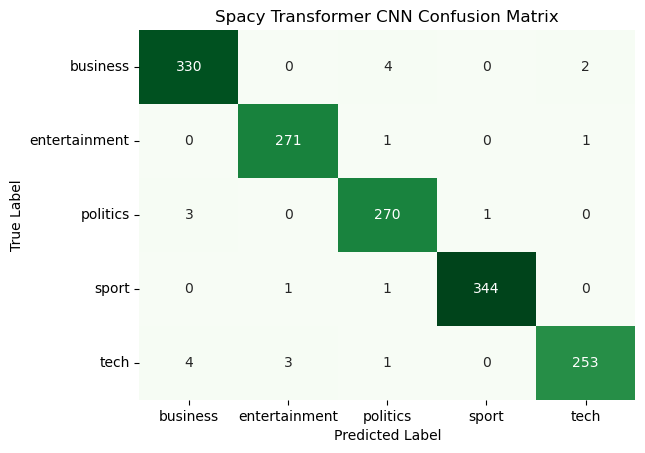

In [53]:
# load the model
nlp_efficiency_gpu = spacy.load("./outputs/efficiency-gpu-model-best")

train_preds = generate_predictions(train, textcat_model=nlp_efficiency_gpu)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, title='Spacy Transformer CNN Confusion Matrix')

In [54]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training accuracy:", accuracy)

f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training F1 score:", f1)

# make predictions
test_preds = generate_predictions(test, label_col=None, textcat_model=nlp_efficiency_gpu)

kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
kaggle_submission.to_csv('./outputs/kaggle submission efficient gpu textcat.csv', index=False)

Training accuracy: 0.9852348993288591
Training F1 score: 0.9852316714422409


Model performance on all datasets was just behind the Bag of Words approach (99% on the training data and 97% on the test data.)

**The fifth and final model trained and evaluated was a transformer-based stacked ensemble model.**

Rejig the config file for **GPU accuracy**.
- Step 1: generate a base config file using https://spacy.io/usage/training#quickstart:
    - Components: textcat
    - Text classification: Exclusive categories
    - Hardware: GPU
    - Optimise for: accuracy
- Step 2: Create a complete config file with all the other components auto-filled to their defaults

In [55]:
# CLI command
!python -m spacy init fill-config ./configs/base_accuracy_gpu_config.cfg ./configs/accuracy_gpu_config.cfg --diff

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
✔ Auto-filled config with all values

============================= START CONFIG DIFF =============================

[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = "pytorch"
seed = 0

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]
batch_size = 128
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}
vectors = {"@vectors":"spacy.Vectors.v1"}

[components]

[components.textcat]
factory = "textcat"
scorer = {"@scorers":"spacy.textcat_scorer.v2"}
threshold = 0.0

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"
n

In [56]:
# view the configuration file
file_path = './configs/accuracy_gpu_config.cfg'
textcat_config = read_spacy_config(file_path)
textcat_config

{'paths': {'train': 'null',
  'dev': 'null',
  'vectors': 'null',
  'init_tok2vec': 'null'},
 'system': {'gpu_allocator': '"pytorch"', 'seed': '0'},
 'nlp': {'lang': '"en"',
  'pipeline': '["transformer","textcat"]',
  'batch_size': '128',
  'disabled': '[]',
  'before_creation': 'null',
  'after_creation': 'null',
  'after_pipeline_creation': 'null',
  'tokenizer': '{"@tokenizers":"spacy.Tokenizer.v1"}',
  'vectors': '{"@vectors":"spacy.Vectors.v1"}'},
 'components': {},
 'components.textcat': {'factory': '"textcat"',
  'scorer': '{"@scorers":"spacy.textcat_scorer.v2"}',
  'threshold': '0.0'},
 'components.textcat.model': {'@architectures': '"spacy.TextCatEnsemble.v2"',
  'no': 'null'},
 'components.textcat.model.linear_model': {'@architectures': '"spacy.TextCatBOW.v2"',
  'exclusive_classes': 'true',
  'ngram_size': '1',
  'no_output_layer': 'false',
  'no': 'null'},
 'components.textcat.model.tok2vec': {'@architectures': '"spacy-transformers.TransformerListener.v1"',
  'grad_factor'

In [57]:
# train the model: https://spacy.io/usage/training#quickstart
# override various config sections using the syntax: --section.option
t0 = time()
!python -m spacy train ./configs/accuracy_gpu_config.cfg --output ./outputs --paths.train ./corpora/train.spacy --paths.dev ./corpora/dev.spacy --gpu-id 0
print("Done in %0.3fm." % ((time() - t0)/60))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'textcat']
ℹ Initial learn rate: 0.0
E    #       LOSS TRANS...  LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------

In [58]:
# evaluate model performance
!python -m spacy evaluate ./outputs/accuracy-gpu-model-best/ ./corpora/train.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   96.98 
SPEED               10387 


=========================== Textcat F (per label) ===========================

                    P       R       F
sport           98.91   98.91   98.91
business        96.28   96.28   96.28
tech            96.59   97.54   97.06
politics        94.12   95.41   94.76
entertainment   99.05   96.74   97.88


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics      

In [59]:
!python -m spacy evaluate ./outputs/accuracy-gpu-model-best/ ./corpora/dev.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   96.85 
SPEED               9047  


=========================== Textcat F (per label) ===========================

                    P        R       F
sport           98.55    98.55   98.55
business        97.01    97.01   97.01
tech            92.73   100.00   96.23
politics        98.04    92.59   95.24
entertainment   98.11    96.30   97.20


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics

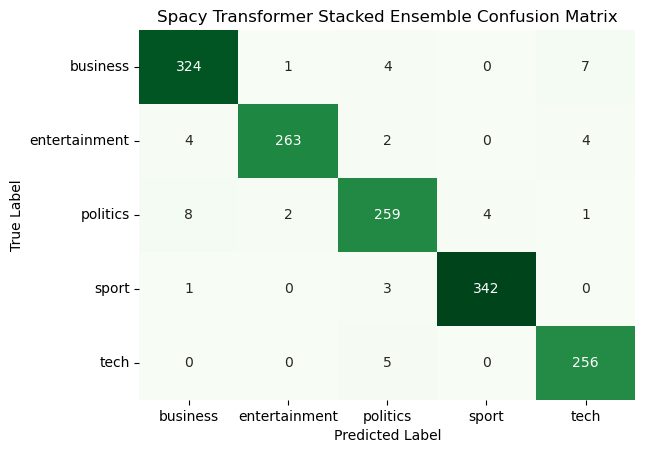

In [62]:
# load the model
nlp_accuracy_gpu = spacy.load("./outputs/accuracy-gpu-model-best")

train_preds = generate_predictions(train, textcat_model=nlp_accuracy_gpu)

plot_confusion_matrix(train_preds.Actual, train_preds.Predicted, title='Spacy Transformer Stacked Ensemble Confusion Matrix')

In [63]:
accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
print("Training accuracy:", accuracy)

f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')
print("Training F1 score:", f1)

# make predictions
test_preds = generate_predictions(test, label_col=None, textcat_model=nlp_accuracy_gpu)

kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
kaggle_submission.columns=['ArticleId', 'Category']
kaggle_submission.to_csv('./outputs/kaggle submission accurate gpu textcat.csv', index=False)

Training accuracy: 0.9691275167785235
Training F1 score: 0.9691410242353468


Model performance was good, but only a slight improvement on the CPU-based stacked ensemble model (97% on the training data and 95% on the test data). The biggest problem areas in the training data were missclassifying political articles as business articles and business articles as tech articles. 

In summary, the results for both the supervised and unsupervised models are:
| Model            | Train accuracy | Train F1 score | Test accuracy | Data Pre-Processing | Model Training                         | Over/Underfitting?                   |
| ---------------- | -------------- | -------------- | ------------- | ------------------- | -------------------------------------- | ------------------------------------ |
| Initial NMF      | 0.9195         | 0.9194         | 0.9278        | Intensive           | Very fast (seconds)                    | N/A but unlikely                     |
| Tuned NMF        | 0.9362         | 0.9362         | 0.9279        | Intensive           | Very fast (seconds)                    | N/A but unlikely                     |
| Textcat BoW      | 0.9946         | 0.9946         | 0.9769        | Simple              | Fast (minutes)                         | No. Train F1: 0.9992; Dev F1: 0.9764 |
| Textcat Ensemble | 0.9490         | 0.9488         | 0.9361        | Simple              | Fast on a GPU (minutes); Slow on a CPU | Unknown due to resource constraints. Train F1: -; Dev F1: 0.9447 |
| Textcat CNN      | 0.9893         | 0.9893         | 0.9442        | Simple              | Fast on a GPU (minutes)                | Perhaps? Train F1: 0.9974; Dev F1: 0.9595 |
| Textcat transformer CNN | 0.9852  | 0.9852         | 0.9714        | Simple  | Slow on a GPU (minutes)                            | No. Train F1: 0.9876; Dev F1: 0.9731 |
| Textcat transformer stacked ensemble | 0.9698 | 0.9685 | 0.9510    | Simple              | Slow on a GPU (minutes)                | No. Train F1: 0.9698; Dev F1: 0.9685 |

In theory, supervised models perform better than unsupervised models because the algorithm is told whether a pair of observations are similar or not (assuming that the labels are accurate) and therefore only has to figure out why. Unsupervised models don't have that - they start with the data and have to figure out how similar pairs of observations are before being able to apply predictions to invidual observations (such as classifying them). This was largely true here to varying degrees as shown in the table above.

What was not consistently true was whether a more sophisticated approach outperformed a simpler approach. However, the author hypothesises that this might be the case because it was a relatively simple classification task. If there was more nuance between the classes, then the Bag of Words approach might have been insufficient to achieve a good result. What was interesting in this case, was that the so-called 'efficient' architectures performed much better than the 'accurate' stacked ensemble architecture.

Finally, if one of these models was going to be put into production, the stakeholders would need to weigh up the lengthier training times associated with a more sophisticated transformer against a fast bag of words that would do just fine with the current dataset.

## Task 7: Data Experiments

The last section of this analysis investigates whether random subsets of the data have any effect on model performance. The model chosen will be the Bag of Words, given it was very fast.

In [64]:
for ts in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
    ts_str = str(ts).replace("0.", "")

    # split the data, notice the absence of the random_state parameter. This means the data subsets extracted each time
    # the data is split will be different (and not reproducible)
    train_data, dev_data = train_test_split(train_sub, stratify=train_sub.Category, test_size=ts)
    train_data.reset_index(inplace=True, drop=True)
    dev_data.reset_index(inplace=True, drop=True)

    # convert the data to spacy's required training format: https://spacy.io/api/data-formats#binary-training
    train_path = "./corpora/train_exp_" + ts_str + ".spacy"
    dev_path = "./corpora/dev_exp_" + ts_str + ".spacy"
    convert_data(train_path, df=train_data)
    convert_data(dev_path, df=dev_data)

{'sport': {'sport': 1, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'business': {'sport': 0, 'business': 1, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'tech': {'sport': 0, 'business': 0, 'tech': 1, 'politics': 0, 'entertainment': 0}, 'politics': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 1, 'entertainment': 0}, 'entertainment': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 1}}
{'sport': {'sport': 1, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'business': {'sport': 0, 'business': 1, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'tech': {'sport': 0, 'business': 0, 'tech': 1, 'politics': 0, 'entertainment': 0}, 'politics': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 1, 'entertainment': 0}, 'entertainment': {'sport': 0, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 1}}
{'sport': {'sport': 1, 'business': 0, 'tech': 0, 'politics': 0, 'entertainment': 0}, 'business': {'sport': 0, 'business': 1, 'tech':

In [66]:
# train the models: https://spacy.io/usage/training#quickstart
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs --paths.train ./corpora/train_exp_05.spacy --paths.dev ./corpora/dev_exp_05.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        7.47    0.07
  0     200         15.44       87.10    0.87
  0     400          5.20       91.86    0.92
  0     600          1.95       94.76    0.95
  0     800          2.89       97.35    0.97
  0    1000          2.14       93.29    0.93
  0    1200          2

In [67]:
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs --paths.train ./corpora/train_exp_1.spacy --paths.dev ./corpora/dev_exp_1.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        7.47    0.07
  0     200         14.38       85.90    0.86
  0     400          4.37       91.65    0.92
  0     600          3.94       93.01    0.93
  0     800          2.68       93.64    0.94
  0    1000          2.53       93.57    0.94
  0    1200          2

In [68]:
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs --paths.train ./corpora/train_exp_15.spacy --paths.dev ./corpora/dev_exp_15.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        7.59    0.08
  0     200         16.52       90.69    0.91
  0     400          5.10       91.65    0.92
  0     600          2.43       96.24    0.96
  0     800          2.82       97.26    0.97
  0    1000          1.95       96.72    0.97
  0    1200          2

In [69]:
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs --paths.train ./corpora/train_exp_2.spacy --paths.dev ./corpora/dev_exp_2.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        7.40    0.07
  0     200         15.96       88.10    0.88
  0     400          4.41       93.25    0.93
  0     600          5.04       94.24    0.94
  0     800          1.50       96.44    0.96
  0    1000          2.34       96.19    0.96
  1    1200          2

In [70]:
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs --paths.train ./corpora/train_exp_25.spacy --paths.dev ./corpora/dev_exp_25.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        7.56    0.08
  0     200         14.33       90.76    0.91
  0     400          3.37       90.98    0.91
  0     600          4.22       95.43    0.95
  0     800          2.56       96.71    0.97
  0    1000          2.50       95.81    0.96
  1    1200          1

In [72]:
!python -m spacy train ./configs/efficiency_cpu_config.cfg --output ./outputs --paths.train ./corpora/train_exp_3.spacy --paths.dev ./corpora/dev_exp_3.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Saving to output directory: outputs
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.16        6.25    0.06
  0     200         16.39       92.44    0.92
  0     400          3.45       93.03    0.93
  0     600          4.31       95.61    0.96
  0     800          2.77       96.53    0.97
  0    1000          1.87       94.27    0.94
  1    1200          0

In [73]:
# evaluate model performance
!python -m spacy evaluate ./outputs/efficiency-cpu-05-model-best/ ./corpora/train_exp_05.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.55 
SPEED               253201


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business         99.69    99.37    99.53
tech             98.77    99.59    99.17
politics         99.61    99.22    99.42
entertainment    99.61    99.61    99.61


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [74]:
!python -m spacy evaluate ./outputs/efficiency-cpu-05-model-best/ ./corpora/dev_exp_05.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   100.00
SPEED               156704


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00   100.00   100.00
tech            100.00   100.00   100.00
politics        100.00   100.00   100.00
entertainment   100.00   100.00   100.00


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [75]:
!python -m spacy evaluate ./outputs/efficiency-cpu-1-model-best/ ./corpora/train_exp_1.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.84 
SPEED               252958


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00    99.67    99.83
tech            100.00    99.56    99.78
politics         99.59   100.00    99.80
entertainment    99.59   100.00    99.79


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [76]:
!python -m spacy evaluate ./outputs/efficiency-cpu-1-model-best/ ./corpora/dev_exp_1.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   95.04 
SPEED               176151


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business         91.67    97.06    94.29
tech             96.00    96.00    96.00
politics         92.59    92.59    92.59
entertainment    96.00    88.89    92.31


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           0.97
tech               0

In [77]:
!python -m spacy evaluate ./outputs/efficiency-cpu-15-model-best/ ./corpora/train_exp_15.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.74 
SPEED               246252


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00   100.00   100.00
tech            100.00    99.54    99.77
politics         99.57    99.57    99.57
entertainment    99.13    99.56    99.35


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [78]:
!python -m spacy evaluate ./outputs/efficiency-cpu-15-model-best/ ./corpora/dev_exp_15.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   98.16 
SPEED               181031


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00    94.12    96.97
tech             97.44   100.00    98.70
politics         95.24    97.56    96.39
entertainment    97.56   100.00    98.77


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           0.98
tech               1

In [79]:
!python -m spacy evaluate ./outputs/efficiency-cpu-2-model-best/ ./corpora/train_exp_2.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.56 
SPEED               245124


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00    98.88    99.44
tech             99.51    99.51    99.51
politics         99.09   100.00    99.54
entertainment    99.07    99.53    99.30


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [80]:
!python -m spacy evaluate ./outputs/efficiency-cpu-2-model-best/ ./corpora/dev_exp_2.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   97.62 
SPEED               194383


=========================== Textcat F (per label) ===========================

                     P       R       F
sport           100.00   98.55   99.27
business         95.59   97.01   96.30
tech             98.04   98.04   98.04
politics         94.64   98.15   96.36
entertainment   100.00   96.30   98.11


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1.00
politics

In [81]:
!python -m spacy evaluate ./outputs/efficiency-cpu-25-model-best/ ./corpora/train_exp_25.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.91 
SPEED               238616


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00    99.60    99.80
tech             99.48   100.00    99.74
politics        100.00   100.00   100.00
entertainment   100.00   100.00   100.00


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [82]:
!python -m spacy evaluate ./outputs/efficiency-cpu-25-model-best/ ./corpora/dev_exp_25.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   97.01 
SPEED               198120


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business         94.12    95.24    94.67
tech             98.44    98.44    98.44
politics         92.75    94.12    93.43
entertainment   100.00    97.01    98.48


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [83]:
!python -m spacy evaluate ./outputs/efficiency-cpu-3-model-best/ ./corpora/train_exp_3.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   99.78 
SPEED               238463


=========================== Textcat F (per label) ===========================

                     P        R        F
sport           100.00   100.00   100.00
business        100.00   100.00   100.00
tech             99.44    99.44    99.44
politics        100.00   100.00   100.00
entertainment    99.47    99.47    99.47


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           1.00
tech               1

In [84]:
!python -m spacy evaluate ./outputs/efficiency-cpu-3-model-best/ ./corpora/dev_exp_3.spacy --gpu-id 0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
ℹ Using GPU: 0

================================== Results ==================================

TOK                 100.00
TEXTCAT (macro F)   96.83 
SPEED               204524


=========================== Textcat F (per label) ===========================

                     P       R       F
sport           100.00   99.03   99.51
business         93.20   95.05   94.12
tech             96.05   96.05   96.05
politics         97.50   95.12   96.30
entertainment    97.56   98.77   98.16


======================== Textcat ROC AUC (per label) ========================

                ROC AUC
sport              1.00
business           0.99
tech               1.00
politics

The evaluation results indicated that there was no real effect on performance in the training data, but speed dropped as the size of the dev set increased. In the dev set results, there was a slight indication that performance decreased but speed increased as the size of the dev set increased.

In [85]:
# Assess the performance of the different models on the actual train and test datasets
cm_list = []
acc_list = []
f1_list = []
for ts_str in ["05", "1", "15", "2", "25", "3"]:
    nlp_efficiency = spacy.load("./outputs/efficiency-cpu-" + ts_str + "-model-best")
    # generate training data predictions
    train_preds = generate_predictions(train, textcat_model=nlp_efficiency)

    # evaluate model performance
    cm = confusion_matrix(y_true=train_preds.Actual, y_pred=train_preds.Predicted)

    accuracy = accuracy_score(train_preds.Actual, train_preds.Predicted)
    f1 = f1_score(train_preds.Actual, train_preds.Predicted, average='weighted')

    # make predictions
    test_preds = generate_predictions(test, label_col=None, textcat_model=nlp_efficiency)

    kaggle_submission = test_preds.loc[:, ['ArticleId', 'PredictedLabel']]
    kaggle_submission.columns=['ArticleId', 'Category']
    kaggle_submission.to_csv('./outputs/kaggle submission efficient textcat' + ts_str + '.csv', index=False)

    cm_list.append(cm)
    acc_list.append(accuracy)
    f1_list.append(f1)

In [91]:
performance_df = pd.DataFrame(data={'Dev size': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
                                    'Accuracy': acc_list,
                                    'F1 score': f1_list,
                                    'Test accuracy': [0.9755, 0.9769, 0.9796, 0.9701, 0.9782, 0.9755]})
performance_df

,Dev size,Accuracy,F1 score,Test accuracy
0,0.05,0.995302,0.995304,0.9755
1,0.10,0.993289,0.993289,0.9769
2,0.15,0.994631,0.994637,0.9796
3,0.20,0.990604,0.990611,0.9701
4,0.25,0.991275,0.991284,0.9782
5,0.30,0.987919,0.987929,0.9755


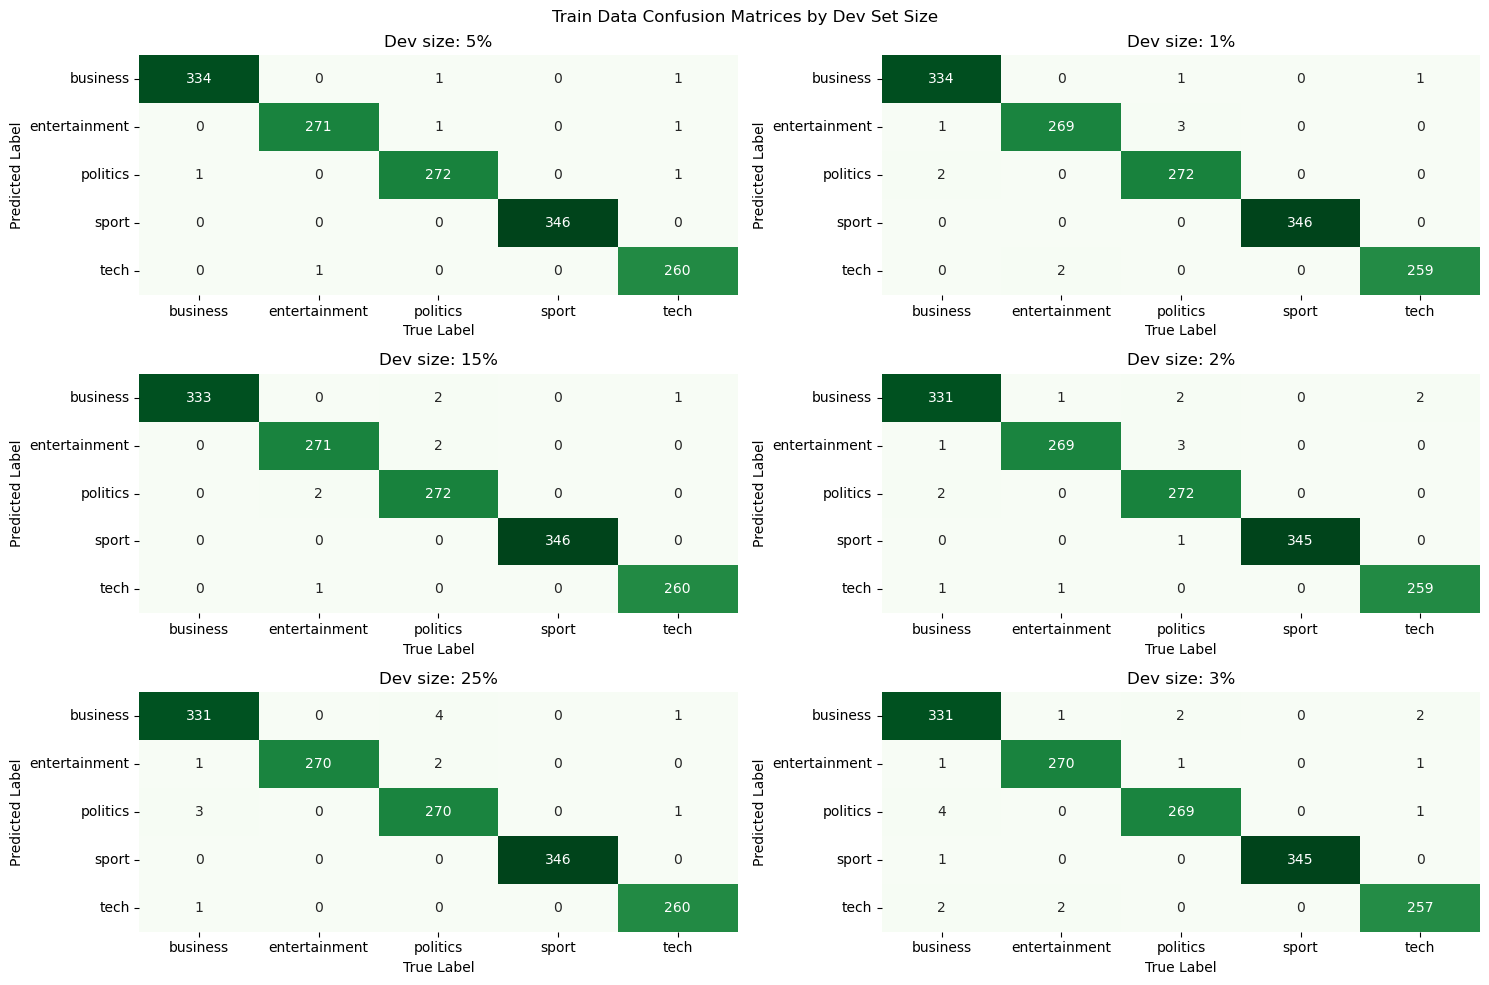

In [90]:
# plot a grid of confusion matrices
ts_str = ["5", "10", "15", "20", "25", "30"]
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for idx, ax in enumerate(axs.flatten()):
    cats = ['business', 'entertainment', 'politics', 'sport', 'tech']
    cm_df = pd.DataFrame(cm_list[idx], columns=cats, index=cats)

    sns.heatmap(cm_df, annot=True, fmt=".0f", cbar=False, cmap="Greens", ax=ax)
    ax.set(xlabel="True Label", ylabel="Predicted Label", title="Dev size: " + ts_str[idx] + "%")
fig.suptitle('Train Data Confusion Matrices by Dev Set Size')
plt.tight_layout()

Again, there was no discernable trend in model performance for different dev set sizes and compositions in the training and test data.